In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split


sns.set_style('white')

# Prediction

For investors it's interesting to know which characteristics of a loan are predictive of a loan ending in charged off. Lending club has its own algorithms beforehand that they use to predict which loans are riskier and give these a grade (A-F). This correlates very well with the probability of charged off as we saw in the exploration of the dataset. The interest rates should reflect the risk (higher interest with more risk) to make the riskier loans still attractive to invest in. Although grade and interest correlates well, it's not a perfect correlation. 

We will here use the loans that went to full term to build classifiers that can classify loans into charged off and fully paid. The accuracy measure used is 'f1_weighted' of sklearn. This score can be interpreted as a weighted average of the precision and recall. Interest rate and grade are already very good classifiers of charged off/fully paid. We will start with using grade as feature for prediction and see which features add any extra value. 

### Select loans and features
We selected the loans here that went to full term and add the characteristic whether they were charged off or not. We excluded the one loan that was a joint application. The number of loans left are 255,719. 

In [2]:
loans = pd.read_csv('../data/loan.csv')
closed_status = ['Fully Paid', 'Charged Off',
              'Does not meet the credit policy. Status:Fully Paid',
              'Does not meet the credit policy. Status:Charged Off']
closed_loans = loans[loans['loan_status'].isin(closed_status)]
paid_status = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
closed_loans['charged_off'] = [False if loan in paid_status else True for loan in closed_loans['loan_status']]

# exclude the one joint application
closed_loans = closed_loans[closed_loans['application_type'] == 'INDIVIDUAL']
closed_loans['grade'] = closed_loans['grade'].astype('category', ordered=True)
closed_loans.shape

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(255719, 75)

### Select features
The features that were missing in more than 5% of the loans were excluded leaving 49 features. 
Subsequently 21 features were handpicked to be features that could have predictive value (plus the features to predict 'charged_off' and 'loan_status'). For instance the 'id' of the loan does not have predicted value. Also features to do with how much was recieved in the end were excluded, since you don't know that at the beginning of a loan and therefore cannot choose a loan to invest in based on those features. 

In [3]:
include =['funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 
          'annual_inc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 
          'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
          'initial_list_status', 'mths_since_last_major_derog', 'acc_now_delinq']
questionable = ['verfication_status', 'issue_d', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
               'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med']
exclude = ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'emp_title', 'loan_status', 'pymnt_plan', 'url', 'desc', 'title', 
          'out_prncp', 'out_prncp_inv', 'total_pymnt', 'last_pymnt_amnt', 'next_pymnt_d', 'policy_code', 'application_type',
          'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_il_6m', 'open_il_12m', 'open_il_24m', 
           'mths_since_rcnt_il', 'total_bal_il']

In [4]:
include =['funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 
          'home_ownership', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_bal', 
          'charged_off', 'loan_status', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
          'pub_rec', 'revol_util', 'total_acc', 'acc_now_delinq' ]

# exclude features with more than 5% missing values
columns_not_missing = (closed_loans.isnull().apply(sum, 0) / len(closed_loans)) < 0.05
closed_loans = closed_loans.loc[:,columns_not_missing[columns_not_missing].index]

# include only the above handpicked features
closed_loans = closed_loans[include]
closed_loans.shape

(255719, 23)

In [5]:
closed_loans.head()

,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,purpose,zip_code,...,charged_off,loan_status,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,acc_now_delinq
0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,credit_card,860xx,...,False,Fully Paid,24000.0,0.0,1.0,3.0,0.0,83.7,9.0,0.0
1,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,car,309xx,...,True,Charged Off,30000.0,0.0,5.0,3.0,0.0,9.4,4.0,0.0
2,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,small_business,606xx,...,False,Fully Paid,12252.0,0.0,2.0,2.0,0.0,98.5,10.0,0.0
3,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,other,917xx,...,False,Fully Paid,49200.0,0.0,1.0,10.0,0.0,21.0,37.0,0.0
5,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,wedding,852xx,...,False,Fully Paid,36000.0,0.0,3.0,9.0,0.0,28.3,12.0,0.0


### Split data
We keep 50% of the data separate for now so we can later use this for hyperparameter tuning of the classifier and have some data separate to reliable test the performance of the classifier. The split is stratified by 'loan_status' in order to equally divide old loans over the split (old loans have a higher 'charged_off' probability). The classes to predict are in the variable 'charged_off'.

In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(closed_loans.iloc[:,0:22], 
                                                    closed_loans['charged_off'], test_size=0.5, 
                                                    random_state=123, stratify=closed_loans['loan_status'])
X_train = X_train.drop(['charged_off', 'loan_status'], axis=1)
X_val_test = X_val_test.drop(['charged_off', 'loan_status'], axis=1)

### Logistic regression

We will first start with the logistic regression classifier. This is a simple classifier that uses a sigmoidal curve to predict from the features to which class the sample belongs. It has one parameter to tune namely the C-parameter. This is the inverse of the regularization strength, smaller values specify stronger regularization. In sklearn the features have to be numerical that we input in this algorithm, so we need to convert the categorical features to numeric. To do this ordered categorical features will have adjacent numbers and unordered features will get an order as best as possible during conversion to numeric, for instance geographical. Also there cannot be nan/inf/-inf values, hence these will be made 0's. With this algorithm scaling/normalizing the features is not necessary. 

Non-numeric features were converted as follows:
- earliest_cr_line: the date was converted to a timestamp number
- grade/sub_grade: order of the letters was kept
- emp_length: nr of years
- zipcode: numbers kept of zipcode (geographical order)
- term: in months
- home_ownership: from none to rent to mortgage to owned
- purpose: from purposes that might make money to purposes that only cost money
- addr_state: ordered geographically from west to east, top to bottom (https://theusa.nl/staten/)


In [7]:
# features that are not float or int, so not to be converted:

# date:
# earliest_cr_line

# ordered:
# grade, sub_grade, emp_length, zip_code, term

# unordered:
# home_ownership, purpose, addr_state (ordered geographically)

# date
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line']).dt.strftime("%s")
X_train['earliest_cr_line'] = [0 if date=='NaT' else int(date) for date in X_train['earliest_cr_line']]

# term
X_train['term'] = X_train['term'].apply(lambda x: int(x.split(' ')[1]))

# grade
loans['grade'] = loans['grade'].astype('category')
grade_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X_train['grade'] = X_train['grade'].apply(lambda x: grade_dict[x])

# emp_length
emp_length_dict = {'n/a':0,
                   '< 1 year':0,
                   '1 year':1,
                   '2 years':2,
                   '3 years':3,
                   '4 years':4,
                   '5 years':5,
                   '6 years':6,
                   '7 years':7,
                   '8 years':8,
                   '9 years':9,
                   '10+ years':10}
X_train['emp_length'] = X_train['emp_length'].apply(lambda x: emp_length_dict[x])

# zipcode
X_train['zip_code'] = X_train['zip_code'].apply(lambda x: int(x[0:3]))

# subgrade
X_train['sub_grade'] = X_train['grade'] + X_train['sub_grade'].apply(lambda x: float(list(x)[1])/10)

# house
house_dict = {'NONE': 0, 'OTHER': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3}
X_train['home_ownership'] = X_train['home_ownership'].apply(lambda x: house_dict[x])

# purpose
purpose_dict = {'other': 0, 'small_business': 1, 'renewable_energy': 2, 'home_improvement': 3,
                'house': 4, 'educational': 5, 'medical': 6, 'moving': 7, 'car': 8, 
                'major_purchase': 9, 'wedding': 10, 'vacation': 11, 'credit_card': 12, 
                'debt_consolidation': 13}
X_train['purpose'] = X_train['purpose'].apply(lambda x: purpose_dict[x])

# states
state_dict = {'AK': 0, 'WA': 1, 'ID': 2, 'MT': 3, 'ND': 4, 'MN': 5, 
              'OR': 6, 'WY': 7, 'SD': 8, 'WI': 9, 'MI': 10, 'NY': 11, 
              'VT': 12, 'NH': 13, 'MA': 14, 'CT': 15, 'RI': 16, 'ME': 17,
              'CA': 18, 'NV': 19, 'UT': 20, 'CO': 21, 'NE': 22, 'IA': 23, 
              'KS': 24, 'MO': 25, 'IL': 26, 'IN': 27, 'OH': 28, 'PA': 29, 
              'NJ': 30, 'KY': 31, 'WV': 32, 'VA': 33, 'DC': 34, 'MD': 35, 
              'DE': 36, 'AZ': 37, 'NM': 38, 'OK': 39, 'AR': 40, 'TN': 41, 
              'NC': 42, 'TX': 43, 'LA': 44, 'MS': 45, 'AL': 46, 'GA': 47, 
              'SC': 48, 'FL': 49, 'HI': 50}
X_train['addr_state'] = X_train['addr_state'].apply(lambda x: state_dict[x])

# make NA's, inf and -inf 0
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)

After the categorical features are conversed to numeric, we will first check what the accuracy is when only using the feature 'grade' (A-F) to predict 'charged off' (True/False). This is the classification lending club gave the loans. The closer to F the higher the chance the loan will end in 'charged off'. For the accuracy estimation we will use 'F1-weighted'. This stands for F1 = 2 * (precision * recall) / (precision + recall). In this way both precision and recall is important for the accuracy. Precision is the number of correct positive results divided by the number of all positive results, and recall is the number of correct positive results divided by the number of positive results that should have been returned. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0. In this case using only 'grade'as feature, using the default parameter value for C (inverse of regularization strength) and using l1/lasso penalization we get an F1-accuracy of 0.744.

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.74657805  0.74363519  0.74353838  0.74487007  0.74262046  0.74428405
  0.74418621  0.74538976  0.74307224  0.7448571 ]
0.744303150168


We will now see whether using all 20 features that we selected will give an higher accuracy than using only 'grade'. This leads to only a very slight bump in the accuracy to 0.749. 

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.75037474  0.74824152  0.74705646  0.75024383  0.75155753  0.74805346
  0.75014022  0.74983419  0.74537033  0.74913791]
0.749001018324


Another way to possibly increase performance is to tune the C (penalization) parameter. We will do this with the GridSearchCV function of sklearn. The best performing C parameter, although really close with the default, is C=1. Giving an accuracy of 0.7497. (code is quoted out because it takes a long time to run)

In [14]:
from sklearn.model_selection import GridSearchCV
dict_Cs = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l1'), dict_Cs, 'f1_weighted', cv=10)

#clf.fit(X_train, y_train)
#print(clf.best_params_)
#print(clf.best_score_)

Which features are most important for this slight bump in accuracy. We can see this by which coefficient is given to the feature by the algorithm. Here we show the 5 features with the highest coefficients, hence given the highest weights by the algorithm for the prediction. Both positive and negative coefficients are considered. We see that next to grade, home ownership is important, interest rates, number of inquiries for other loans in the last 6 months and number of times failing to pay in the last 2 years. Below these features are visualized in relation to the charged off status. 

In [15]:
clf = LogisticRegression(penalty='l1', C=1)
clf.fit(X_train, y_train)
coefs = clf.coef_

# find index of top 5 highest coefficients, aka most used features for prediction
positions = abs(coefs[0]).argsort()[-5:][::-1]
print(X_train.columns[positions])
print(coefs[0][positions])

Index(['home_ownership', 'int_rate', 'inq_last_6mths', 'grade', 'delinq_2yrs'], dtype='object')
[-0.11586405  0.11313648  0.08153957 -0.04397259  0.03575021]


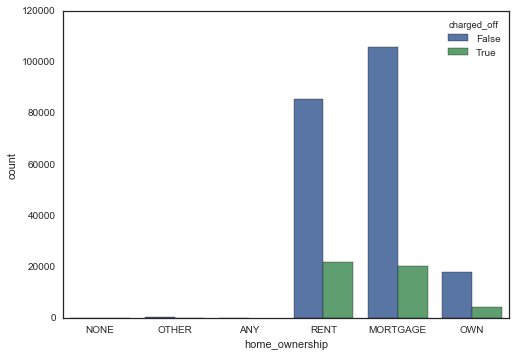

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


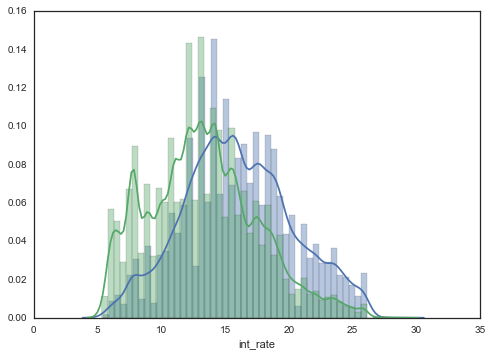

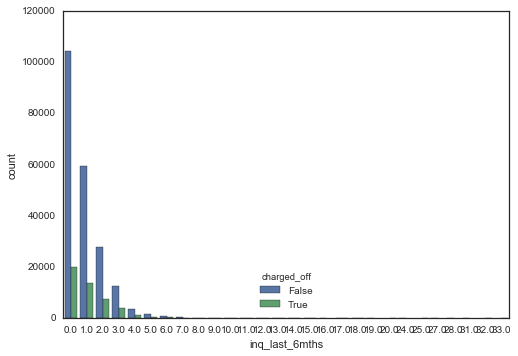

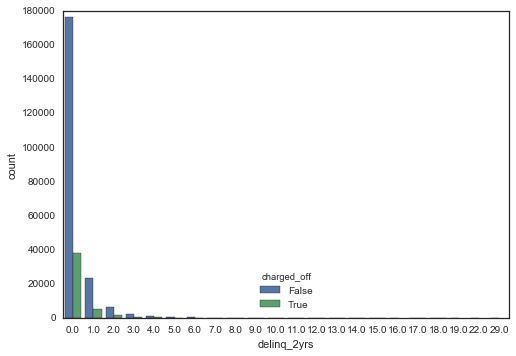

In [16]:
closed_loans['home_ownership'] = closed_loans['home_ownership'].astype('category')
closed_loans['home_ownership'] = (closed_loans['home_ownership']
                                 .cat.reorder_categories(['NONE', 'OTHER', 'ANY', 'RENT', 'MORTGAGE', 'OWN']))
sns.countplot(data=closed_loans, x='home_ownership', hue='charged_off')
plt.show()
sns.distplot(closed_loans[closed_loans['charged_off']==True]['int_rate'])
sns.distplot(closed_loans[closed_loans['charged_off']==False]['int_rate'])
plt.show()
sns.countplot(data=closed_loans, x='inq_last_6mths', hue='charged_off')
plt.show()
sns.countplot(data=closed_loans, x='delinq_2yrs', hue='charged_off')
plt.show()

### Random Forest

To improve accuracy levels we could use a more complicated algorithm that scores well in a lot of cases, namely random forest. This algorithm makes various decision trees from subsets of the samples and uses at each split only a fraction of the features to prevent overfitting. The random forest algorithm is known to be not very sensitive to the values of its parameters: the number of features used at each split and the number of trees in the forest. The algorithm has feature selection already builtin (at each split). Comparing using only 'grade' to using all 20 features the accuracy goes up slightly from 0.739 to 0.753. Using all features gives also a slightly better result than logistic regression with all features and parameter tuning.  

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train.loc[:,['grade']], y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

# why do I get this F-score warning?

/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ro.d.bruijn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/r

[ 0.73897316  0.73897316  0.73897316  0.73897316  0.73906272  0.73904307
  0.73904307  0.73904307  0.73904307  0.73904307]
0.7390170732


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_weighted')
print(scores)
print(np.mean(scores))

[ 0.75375195  0.75571699  0.75613842  0.75208183  0.74999355  0.75437603
  0.75508423  0.75361816  0.75527093  0.75505198]
0.754108407175


In [ ]:
# TO DO:

# - find which variables are most important to random forest plus make figures of these
# - why F-score warning
# - run algorithms on test set to validate performance

# Miscellaneous

In [ ]:
closed_loans.describe()

In [ ]:
sns.regplot(closed_loans.int_rate, closed_loans.installment)

In [ ]:
# logistic regression, GBM, Random Forest
# train (60%), val (20%), test (20%) adviced by Andrew Ng

# cross_val_score
# f1_weighted
# StratifiedKFold: stratified? for loan_status/paid? --> predefined splits?

# http://scikit-learn.org/stable/modules/feature_selection.html
# SelectKBest or SelectPercentile
# The methods based on F-test estimate the degree of linear dependency between two random variables. 
# On the other hand, mutual information methods can capture any kind of statistical dependency, 
# but being nonparametric, they require more samples for accurate estimation.
# So use mutual_info_classif

# print(accuracy_score(clf.predict(Xtestlr),ytestlr))

# preprocessing: http://scikit-learn.org/stable/modules/preprocessing.html

In [ ]:
# feature selection outside of an algorithm, see if adding one feature increases performance

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
new_X = (SelectKBest(mutual_info_classif, k=5)
        .fit_transform(X_train.drop(['grade'], axis=1), y_train))

clf = LogisticRegression()
for i in range(0,new_X.shape[1]):
    train = X_train.loc[:,['grade']]
    train['new_feature'] = new_X[:,i]
    scores = cross_val_score(clf, train, y_train, cv=10, scoring='f1_weighted')
    print(round(np.mean(scores),3))